# copilotkit

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# Define State
from typing_extensions import TypedDict
from typing import List, Optional
from langgraph.graph import MessagesState


class Step(TypedDict):
    """
    Represents a step taken in the research process.
    """

    id: str
    description: str
    status: str
    type: str
    description: str
    search_result: Optional[str]
    result: Optional[str]
    updates: Optional[List[str]]


class AgentState(MessagesState):
    """
    This is the state of the agent.
    It is a subclass of the MessagesState class from langgraph.
    """

    model: str = "openai"
    steps: List[Step]
    answer: Optional[str]

In [3]:
import uuid
import json
from typing import List, Optional, Any, Union, Dict, Callable
import asyncio

from langchain_core.messages import (
    HumanMessage,
    SystemMessage,
    BaseMessage,
    AIMessage,
    ToolMessage,
)
from langchain_core.runnables import RunnableConfig
from langchain_core.callbacks.manager import adispatch_custom_event
from typing import TypedDict
from enum import Enum
from typing_extensions import NotRequired

In [4]:
import os
from langchain_core.language_models.chat_models import BaseChatModel


def get_model(state: AgentState) -> BaseChatModel:
    """
    Get a model based on the environment variable.
    """
    model = state.get("model")

    if model == "openai":
        from langchain_openai import (
            ChatOpenAI,
        )  # pylint: disable=import-outside-toplevel

        return ChatOpenAI(temperature=0, model="gpt-4o")
    if model == "anthropic":
        from langchain_anthropic import (
            ChatAnthropic,
        )  # pylint: disable=import-outside-toplevel

        return ChatAnthropic(temperature=0, model="claude-3-5-sonnet-20240620")
    if model == "google_genai":
        from langchain_google_genai import (
            ChatGoogleGenerativeAI,
        )  # pylint: disable=import-outside-toplevel

        return ChatGoogleGenerativeAI(temperature=0, model="gemini-1.5-pro")

    raise ValueError("Invalid model specified")

In [5]:
from typing import List
from datetime import datetime
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain.tools import tool
from pydantic import BaseModel, Field


from pydantic import BaseModel, Field
from typing import Literal


class TaskStep(BaseModel):
    """Model for a task step, including search and response generation."""

    id: str = Field(
        description="Unique identifier for the step. Used to track the step in the process."
    )
    description: str = Field(
        description='Detailed description of the step, e.g., "Search for the latest AI news" or "Summarize the findings."'
    )
    status: Literal["pending", "in_progress", "completed"] = Field(
        description='Current status of the step. Values: "pending", "in_progress", "completed".'
    )
    type: Literal["search"] = Field(
        description='Type of the task. "search" for information retrieval'
    )
    data: dict = Field(
        default_factory=dict,
        description="Optional data associated with the step, such as search results for 'respond' steps.",
    )


@tool
def TaskTool(steps: List[TaskStep]):  # pylint: disable=invalid-name,unused-argument
    """
    Break the user's query into smaller steps.
    Use step type "search" to search the web for information
    Make sure to add all the steps needed to answer the user's query.
    """


async def steps_node(state: AgentState, config: RunnableConfig):
    """
    The steps node is responsible for building the steps in the research process.
    """

    instructions = f"""
You are an assistant specialized in search tasks. Your role is to break down complex user queries into smaller, manageable steps.

These steps are then executed serially. In the end, a final answer is produced in markdown format. If user's query is simple, you can directly provide the answer.

The current date is {datetime.now().strftime("%Y-%m-%d")}.
"""

    response = (
        await get_model(state)
        .bind_tools([TaskTool], tool_choice="TaskTool")
        .ainvoke(
            [
                state["messages"][0],
                HumanMessage(content=instructions),
            ],
            config,
        )
    )

    if len(response.tool_calls) == 0:
        steps = []
    else:
        steps = response.tool_calls[0]["args"]["steps"]

    if len(steps) != 0:
        steps[0]["updates"] = ["Searching the web..."]

    return {
        "steps": steps,
    }

In [6]:
import json
from datetime import datetime
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_community.tools import TavilySearchResults


async def search_node(state: AgentState, config: RunnableConfig):
    """
    The search node is responsible for searching the internet for information.
    """
    tavily_tool = TavilySearchResults(
        max_results=3,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=True,
        include_images=False,
    )

    current_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )

    if current_step is None:
        raise ValueError("No step to search for")

    if current_step["type"] not in ["search"]:
        raise ValueError("Current step is not a search step")

    instructions = f"""
This is a step in a series of steps that are being executed to answer the user's query.
These are all of the steps: {json.dumps(state["steps"])}

You are responsible for carrying out the step: {json.dumps(current_step)}

The current date is {datetime.now().strftime("%Y-%m-%d")}.

This is what you need to search for, please come up with multiple good search queries: {current_step["description"]}
"""
    model = get_model(state).bind_tools([tavily_tool], tool_choice=tavily_tool.name)

    response = await model.ainvoke(
        [state["messages"][0], HumanMessage(content=instructions)], config
    )

    tool_msg = await tavily_tool.ainvoke(response.tool_calls[0])

    current_step["search_result"] = json.loads(tool_msg.content)
    current_step["updates"] = [*current_step["updates"], "Extracting information..."]

    return state

In [7]:
import json

from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig


async def extract_node(state: AgentState, config: RunnableConfig):
    """
    The extract node is responsible for extracting information from a tavily search.
    """

    current_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )

    if current_step is None:
        raise ValueError("No current step")

    if current_step["type"] != "search":
        raise ValueError("Current step is not of type search")

    system_message = f"""
This step was just executed: {json.dumps(current_step)}

This is the result of the search:

Please summarize ONLY the result of the search and include all relevant information from the search and reference links.
DO NOT INCLUDE ANY EXTRA INFORMATION. ALL OF THE INFORMATION YOU ARE LOOKING FOR IS IN THE SEARCH RESULTS.

DO NOT answer the user's query yet. Just summarize the search results.

Use markdown formatting and put the references inline and the links at the end.
Like this:
This is a sentence with a reference to a source[1] and another reference[2].
[1]: [Title of Source 1](http://example.com/source1)
[2]: [Title of Source 2](http://example.com/source2)
"""

    response = await get_model(state).ainvoke(
        [state["messages"][0], HumanMessage(content=system_message)], config
    )

    current_step["result"] = response.content
    current_step["search_result"] = None
    current_step["status"] = "complete"
    current_step["updates"] = [*current_step["updates"], "Done."]

    next_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )
    if next_step:
        next_step["updates"] = ["Searching the web..."]

    return state

In [8]:
import json
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain.tools import tool
from pydantic import BaseModel, Field


class Reference(BaseModel):
    """Model for a reference"""

    title: str = Field(description="The title of the reference.")
    url: str = Field(description="The url of the reference.")


class FinalResponse(BaseModel):
    """Input for the summarize tool"""

    markdown: str = Field(
        description="The markdown formatted final response. If you add any headings, make sure to start at level (##)."
    )
    references: list[Reference] = Field(description="A list of references.")


@tool(args_schema=FinalResponse)
def ResponseTool(
    response: str, references: list[Reference]
):  # pylint: disable=invalid-name,unused-argument
    """
    The final result response. Make sure that the response is complete and
    includes all relevant information and reference links.
    """


async def response_node(state: AgentState, config: RunnableConfig):
    """
    The response node is responsible for summarizing the information.
    """

    system_message = f"""
The system has performed a series of steps to answer the user's query.
These are all of the steps: {json.dumps(state["steps"])}

Do your best to answer the user's query in a clear and concise manner.

Use markdown formatting and put the references inline and the links at the end.
Like this:
This is a sentence with a reference to a source[1] and another reference[2].
[1]: [Title of Source 1](http://example.com/source1)
[2]: [Title of Source 2](http://example.com/source2)
"""

    response = (
        await get_model(state)
        .bind_tools([ResponseTool], tool_choice="ResponseTool")
        .ainvoke(
            [
                state["messages"][0],
                HumanMessage(content=system_message),
            ],
            config,
        )
    )

    return {
        "answer": response.tool_calls[0]["args"],
    }

In [9]:
# Define Graph

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver


def task_router(state):
    """Route to research nodes."""
    if not state.get("steps", None):
        return END

    current_step = next(
        (step for step in state["steps"] if step["status"] == "pending"), None
    )

    if not current_step:
        return END

    if current_step["type"] == "search":
        return "search_node"

    elif current_step["type"] == "respond":
        return "response_node"

    raise ValueError(f"Unknown step type: {current_step['type']}")


# Define a new graph
workflow = StateGraph(AgentState)
workflow.add_node("steps_node", steps_node)
workflow.add_node("search_node", search_node)
workflow.add_node("response_node", response_node)
workflow.add_node("extract_node", extract_node)
# Chatbot
workflow.set_entry_point("steps_node")

workflow.add_conditional_edges(
    "steps_node", task_router, ["response_node", "search_node", END]
)

workflow.add_edge("search_node", "extract_node")

workflow.add_conditional_edges(
    "extract_node", task_router, ["response_node", "search_node"]
)

workflow.add_edge("response_node", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

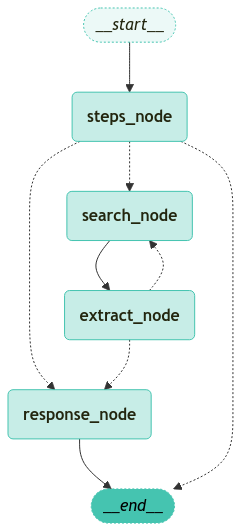

In [10]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(graph)

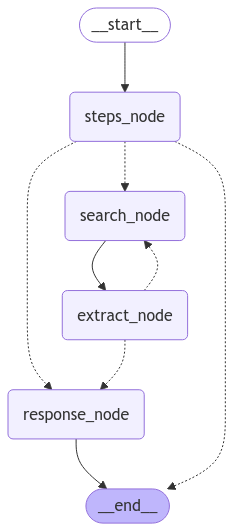

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Visualize the compiled StateGraph as a Mermaid diagram
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [12]:
from pprint import pprint

In [13]:
import asyncio
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    LangGraph의 실행 결과를 비동기 방식으로 스트리밍하여 출력하는 함수입니다.

    매개변수:
    - graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
    - inputs (dict): 그래프에 전달할 입력값 딕셔너리
    - config (RunnableConfig): 실행 설정
    - node_names (List[str], optional): 출력할 노드 이름 목록 (빈 리스트면 모든 노드 출력)
    - callback (Callable[[Dict[str, str]], None], optional): 각 청크 처리를 위한 콜백 함수 (기본값: None)
      콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    반환값:
    - None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 포함된 경우에만 처리
        if not node_names or curr_node in node_names:
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # 노드가 변경될 때마다 헤더를 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 60)
                    print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
                    print("=" * 60)

                # 쿼리 정보가 있으면 출력
                tool_calls = chunk_msg.additional_kwargs.get("tool_calls", [])
                if tool_calls:
                    # print(f"🔍 Query: ", end="")
                    for tool_call in tool_calls:
                        query = tool_call.get("function", {}).get("arguments", "")
                        if query:

                            print(f"{query}", end="", flush=True)
                else:
                    # 쿼리 정보가 없으면 content 출력
                    content = chunk_msg.content
                    if content:
                        print(content, end="", flush=True)

            prev_node = curr_node

In [14]:
config = {
    "configurable": {
        "thread_id": 2,  # temporary thread ID for testing
    },
}

inputs = AgentState(
    model="openai",
    messages=[
        HumanMessage(
            content="How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?"
        )
    ],
    steps=[],
    answer=None,
)

In [15]:
await astream_graph(graph, inputs, config=config)


🔄 Node: steps_node 🔄
{"steps":[{"id":"1","description":"Search for the current market capitalization of Microsoft.","status":"pending","type":"search"},{"id":"2","description":"Search for the current market capitalization of Apple.","status":"pending","type":"search"},{"id":"3","description":"Calculate the difference between Apple's and Microsoft's market capitalizations to determine how much Microsoft's market cap needs to increase to exceed Apple's.","status":"pending","type":"calculation"}]}
🔄 Node: search_node 🔄
{"query":"current market capitalization of Microsoft February 2025"}How much does Microsoft’s market cap need to increase to exceed Apple’s market cap?
🔄 Node: extract_node 🔄
Microsoft's market capitalization is reported as $3.07 trillion according to one source[1], while another source states it as $3.2 trillion[2]. A third source mentions that Microsoft's market cap is $3,264.28 billion, which is approximately $3.26 trillion[3].

[1]: [MarketBeat](https://www.marketbeat.

ValueError: Unknown step type: calculation

In [ ]:
graph.get_state(config).values

In [ ]:
from IPython.display import Markdown

Markdown(graph.get_state(config).values["answer"]["markdown"])

In [ ]:
pprint(graph.get_state(config).values["answer"]["references"])